In [ ]:
# https://blog.finxter.com/how-to-create-an-interactive-web-application-using-jupyter-notebook/
# https://github.com/binder-examples/voila
# https://github.com/voila-dashboards/voila/tree/stable/notebooks
# https://voila-gallery.org/
from pyproj import Transformer, CRS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib ipympl
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'  # "browser" for pycharm, "notebook" for jupyter
#import kaleido  # to render graphs in plotly as images
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from io import StringIO
import base64
import csv
import os
import time
import ipywidgets as widgets
#from ipyevents import Event
from IPython.display import display, clear_output, HTML # Start writing code here...
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
# https://github.com/jupyter-widgets/ipywidgets/issues/3445
# https://github.com/plotly/plotly.py/blob/master/CHANGELOG.md#jupyterlab-versions
# https://ipywidgets.readthedocs.io/en/7.6.3/examples/Widget%20Styling.html

In [ ]:
DATA_URL = 'https://gist.githubusercontent.com/chriddyp/cb5392c35661370d95f300086accea51/raw/8e0768211f6b747c0db42a9ce9a0937dafcbd8b2/indicators.csv'
EXPLANATION = """\
<div class="app-sidebar">
<p><em>Upload excel files with coordinates in local systems and convert them.</em><p>

<p>The excel file must have 3 columns (Element name, Easting/Rechtswert and Northing/Hochwert).
The app will try to tell you the right local systems, but a try-and-error approach is also possible.</p>

<p>Information on Gauß-Krüger can be found here <a href="https://de.wikipedia.org/wiki/Gau%C3%9F-Kr%C3%BCger-Koordinatensystem">
Gauß-Krüger documentation</a>.</p>

<p>To download the converted coordinates, choose the language of your laptop.
If the file is not readable, try with the standard one (English)</a>.</p>

<p>Original github repository: <a href="https://github.com/paofan86/Webapps">GitHub</a>.
</div>
"""

In [ ]:
HTML("""\
<style>
.app-subtitle {
    font-size: 1.5em;
}

.app-subtitle a {
    color: #106ba3;
}

.app-subtitle a:hover {
    text-decoration: underline;
}

.app-sidebar p {
    margin-bottom: 1em;
    line-height: 1.7;
}

.app-sidebar a {
    color: #106ba3;
}

.app-sidebar a:hover {
    text-decoration: underline;
}
</style>
""")

In [ ]:
class App:
    
    def __init__(self):
        self._df_local = pd.DataFrame(data={'Element name': 'P1', 'Easting/Rechtswert': 0,\
                                'Northing/Hochwert': 0}, index=[0])
        self._df_global = pd.DataFrame(data={'Element name': 'P1', 'North': 0,\
                                'East': 0}, index=[0])
        self._upload = self._create_upload_button()
        self._tbl = widgets.Output(layout={'border': '1px solid black', 'align_items': 'center'})  # show dataframe
        self._plot_container1 = go.FigureWidget(layout=go.Layout(dragmode='pan'))  # plot local points
        self._plot_container2 = go.FigureWidget()  # plot global points
        self._text_on_systems = widgets.HTML() # show tips for the user
        self._sys_drop = self._create_system_dropdown()
        self._download_button = self._create_download_button()
        self._lang_dropdown = self._create_lang_dropdown()
        self._link = widgets.Output(layout={'align_items': 'center'})
        _app_container = widgets.VBox([
            self._upload,
            self._tbl,
            self._plot_container1,
            self._text_on_systems,
            self._sys_drop,
            self._plot_container2,
            self._download_button,
            self._lang_dropdown,
            self._link
        ], layout=widgets.Layout(align_items='center', flex='3 0 auto'))
        self.container = widgets.VBox([
            widgets.HTML(
                (
                    '<h1>Coordinate converter for DACH region</h1>'
                    '<h2 class="app-subtitle"><a href="https://github.com/paofan86/Webapps/blob/main/Coord_app.ipynb">(Link to code)</a></h2>'
                ), 
                layout=widgets.Layout(margin='0 0 5em 0', align_items='center', width='75%')
            ),
            widgets.HBox([
                _app_container, 
                widgets.HTML(EXPLANATION, layout=widgets.Layout(margin='0 0 0 2em', align_items='center'))
            ])
        ], layout=widgets.Layout(flex='1 1 auto', margin='0 auto 0 auto', max_width='1024px', align_items='center'))
        self._download_button.on_click(self.create_download_link)
        self._update_app()
        
    @classmethod
    # get filename from FileUpload dict
    def get_name(file_upload):
        if len(file_upload) == 0:
            return ''
        return next(iter(file_upload.values()))['metadata']['name']
    
    # display dataframe
    def setup():
        self._df_local.head()
        
    def _create_upload_button(self):
        upload = widgets.FileUpload(accept='.xlsx', multiple=False)
        upload.observe(self._on_change, names=['value'])
        return upload
    
    def _create_system_dropdown(self):
        # https://blog.finxter.com/how-to-create-an-interactive-web-application-using-jupyter-notebook/
        w = widgets.Dropdown(
            options=['GK Zone 2 - EPSG:31466', 'GK Zone 3 - EPSG:31467',
            'GK Zone 4 - EPSG:31468', 'GK Zone 5 - EPSG:31469',
            'UTM ZONE 32 - EPSG:32632',
            'UTM ZONE 33 - EPSG:32633',
            'MGI Austria GK West - EPSG:31254',
            'MGI Austria GK Central - EPSG:31255',
            'MGI Austria GK East - EPSG:31256',
            'MGI Austria GK M28 - EPSG:31257',
            'MGI Austria GK M31 - EPSG:31258',
            'MGI Austria GK M34 - EPSG:31259',
            'CH1903+ / LV95 (Switzerland) - EPSG:2056'],
            value=None,
            description='Coordinate system:',
            style={'description_width': 'initial'})
        w.observe(self._on_change, names=['value'])
        return(w)

    def _update_system_text(self):
        if len(self._df_local) > 2:
            descr = 'Choose a german \"GK Zone\". To determine if a GK zone is 2,3, 4 or 5, <br>' + \
                'look at the first number in the Easting/Rechtswert/X column. For Austria, try the other MGI systems iteratively. <br>' + \
                'Only one system is available for Switzerland. <br>'
            if str(self._df_local['X'][0]).find('.') == 6:
                descr = descr + 'The coordinates could be in UTM, please try that system also.' + '<br>' \
                                'First number in Easting is ' + str(self._df_local['X'][0])[0] + ',<br>' \
                                'so it should be Zone ' + str(self._df_local['X'][0])[0] + '<br>' \
                                'if the coordinates are in Germany.'
            elif str(self._df_local['X'][0]).find('.') <= 2 and str(self._df_local['X'][0]).find('.') >=1:
                descr = 'Probably the uploaded coordinates are already in WGS84.'
            else:
                descr = descr + 'First number in Easting is ' + str(self._df_local['X'][0])[0] + '' \
                                ', so it should be Zone ' + str(self._df_local['X'][0])[0] + ' ' \
                                'if the coordinates are in Germany.'
        else:
            descr = 'Here the system will try to deduce what type of coordinates are uploaded'
        #text = widgets.Text(value=descr, description='', disabled=True,
        #                   display='flex', flex_flow='column', height='85px',
        #                   width='30%')
        text = widgets.HTML(value= '<style>p{word-wrap: break-word; "margin-bottom:0;}</style> <p>'+ descr +' </p>')
        text.observe(self._on_change, names=['value'])
        self._text_on_systems.value = '<style>p{word-wrap: break-word}</style> <p>'+ descr +' </p>'
        return text
    
    def _create_download_button(self):
        # The button widget and the on_click should be created (or initialised) in the init method
        # https://stackoverflow.com/questions/55763382/get-ipywidget-button-within-a-class-to-access-class-parameters-through-self
        button = widgets.Button(
                    description='Download',
                    disabled=False,
                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                    tooltip='Download the converted coordinates',
                    icon='download'
                    )
        button.layout.visibility = "hidden"
        return button
    
    def _create_lang_dropdown(self):
        dropdown = widgets.Dropdown(options=['English (,)', 'German(;)'],
            value=None,
            description='Laptop language:',
            style={'description_width': 'initial'})
        #dropdown.observe(self._on_change, names=['value'])
        dropdown.layout.visibility = "hidden"
        return dropdown     
    
    def show_it(self):
        if self._upload._counter == 0:  #self._upload.value != {}:
            tbl = pd.DataFrame(data={'Element name': 'P1', 'Easting/Rechtswert': 0,\
                                'Northing/Hochwert': 0}, index=[0])
        else:
            uploaded = False # boolean to see if the dataframe is successfully uploaded, in order to change the column names
            uploaded_filename = next(iter(self._upload.value))
            input_file = list(self._upload.value.values())[0]
            content = input_file['content']  # equal to upload.data[0]
            if uploaded_filename.find('.xlsx') != -1 or uploaded_filename.find('.xlsm') != -1:
                tbl = pd.read_excel(content, header=0, engine='openpyxl')
                uploaded = True
            elif uploaded_filename.find('.xls') != -1:
                tbl = pd.read_excel(content, header=0, engine='xlrd')
                uploaded = True
            elif uploaded_filename.find('.csv') != -1:
                content = StringIO(content.decode('utf-8'))
                sniffer = csv.Sniffer()
                sniffer.preferred = [';', ',']
                dialect = sniffer.sniff(content)
                tbl = pd.read_csv(content, delimiter=dialect.delimiter, header=0)
                uploaded = True
            elif uploaded_filename.find('.txt') != -1:
                content = StringIO(content.decode('utf-8'))
                tbl = pd.read_csv(content, sep=" ", header=None)
                uploaded = True
            if uploaded:
                # prepare dataframe
                tbl = tbl.rename(columns={tbl.columns[0]: 'Element', tbl.columns[1]: 'X', tbl.columns[2]: 'Y'})
                tbl = tbl.iloc[0:,0:3]
                # drop all but the X and Y columns
                try:
                    tbl = tbl.astype({'X': 'float64', 'Y': 'float64'})
                except:
                    print('The file must include 3 columns: Element name, Rechtswert/East/X, Hochswert/North/Y')
                    tbl = pd.DataFrame(data={'Element name': 'P1', 'Easting/Rechtswert': 0,\
                                'Northing/Hochwert': 0}, index=[0])
            else:
                print('Unknown file format')
                tbl = pd.DataFrame(data={'Element name': 'P1', 'Easting/Rechtswert': 0,\
                                'Northing/Hochwert': 0}, index=[0])
            with self._tbl:
                display(tbl.head(5))
                self._df_local = tbl
        #if self._upload._counter != 0:
            #print(uploaded_filename + ' uploaded')
            
    def _calculate(self):
        if self._sys_drop.value != None:
            source = self._sys_drop.value[self._sys_drop.value.find('EPSG')::]
            print(source)
            proj_target = CRS.from_string("epsg:4326")  # wgs84
            proj_source = CRS.from_string(source)  # source system
            # for austrian system, Y and X are the normal ones.
            # For german, Y=Hochwert is cartesian X, X=Rechtswert is cartesian Y
            if self._sys_drop.value.find('GK') != -1:
                x = self._df_local['Y']; y = self._df_local['X']
            elif self._sys_drop.value.find('Switzerland') != -1:
                x = self._df_local['Y']; y = self._df_local['X']
            else:
                x = self._df_local['X']; y = self._df_local['Y']
            transformer = Transformer.from_crs(proj_source, proj_target)
            (nx, ny) = transformer.transform(x, y)
            nx = np.array(nx)[np.newaxis]; nx = nx.T; ny = np.array(ny)[np.newaxis]; ny = ny.T
            conv_tbl = pd.DataFrame(data=nx, columns=['North']); conv_tbl['East'] = ny;
            conv_tbl['Element'] = ''; conv_tbl['Element'].iloc[0:] = self._df_local['Element']
            conv_tbl = conv_tbl[['Element','North', 'East']]
            conv_tbl = conv_tbl.astype({'North': 'float64', 'East': 'float64'})
            self._df_global = conv_tbl
            print(str(self._df_global['North'].iloc[0]) + ',' + str(self._df_global['East'].iloc[0]))
            self._download_button.layout.visibility = "visible"
            self._lang_dropdown.layout.visibility = "visible"


    def _create_plot1(self):
        try:
            if len(self._df_local) > 1:
                if str(self._df_local['X'][0]).find('.') > 2: # draw the points in local coordinates
                    self._plot_container1.data = []; self._plot_container1.layout = {};
                    # to remove just some traces, use: fig.data = [fig.data[0], fig.data[2]]
                    self._plot_container1.add_scatter(x=self._df_local[self._df_local.columns[1]], y=self._df_local[self._df_local.columns[2]],
                                                       mode='markers', hovertemplate=self._df_local[self._df_local.columns[0]], name='Elements in local system')
                    self._plot_container1.layout.title =  {
                         'text': "Points in local system",
                         'y':0.9, # new
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top' # new
                        }
                    self._plot_container1.layout.xaxis.range = (self._df_local[self._df_local.columns[1]].min-2000,self._df_local[self._df_local.columns[1]].max+2000)
                    #fig1 = px.scatter(self._df_local,
                        #x=self._df_local.columns[1],
                        #y=self._df_local.columns[2],
                        #width=600,  # Width of graph
                        #height=500,  # Height of graph
                        ##color="region",
                        #hover_name=self._df_local.columns[0],
                        ##animation_frame = self._df_local.columns[0]
                        #)
                    #fig1.show(renderer="colab", config=dict({'scrollZoom': True}))
                    # give the user some advices
                    if len(self._df_local) > 2:
                        print('Choose a german \"GK Zone\". To determine if a GK zone is 2,3, 4 or 5, \n' + \
                            'look at the first number in the Easting/Rechtswert column.\nFor Austria, try the other MGI systems iteratively.\n' + \
                            'Only one system is available for Switzerland.')
                        if str(self._df_local['X'][0]).find('.') == 6:
                            print('The coordinates could be in UTM, please try that system also.')
                        else:
                            print('First number in Easting is ' + str(self._df_local['X'][0])[0] + \
                                    ', so it should be Zone ' + str(self._df_local['X'][0])[0] + \
                                    '\nif the coordinates are in Germany.\n\r')
                else:
                    print('Probably the uploaded coordinates are already in WGS84.')
        except:
            print('Check the file, system could produce a drawing')
            
    
    def _create_plot2(self):
        try:
             if len(self._df_global) > 1:
                if str(self._df_global['North'][0]).find('.') <= 2: # draw the points in global coordinates (with map)
                    self._plot_container2.data = []; self._plot_container2.layout = {}; self._plot_container2.layout.mapbox = {}
                    # to remove just some traces, use: fig.data = [fig.data[0], fig.data[2]]
                    self._plot_container2.add_scattermapbox(lat=self._df_global['North'], lon=self._df_global['East'],
                                                        mode='markers', marker=go.scattermapbox.Marker(size=8),
                                                        hovertemplate=self._df_global['Element'],
                                                        marker_color = 'blue', name='Elements in wgs84'
                                                        )
                    # https://plotly.com/python/mapbox-layers/
                    # https://plotly.com/python/reference/layout/ for general layout
                    # https://plotly.com/python/reference/layout/mapbox/ for mapbox layout
                    self._plot_container2.update_layout(dict(title_text='Points in wgs84', title_x=0.5, showlegend=False, legend_title='Elements on Gmaps'))
                    self._plot_container2.update_mapboxes(center={'lat': self._df_global['North'].mean(), 'lon': self._df_global['East'].mean()},
                                                          style = "open-street-map", zoom=14)
                                                          
                                                    #mapbox: {'style': "open-street-map", 'center': {'lat': self._df_global['North'].mean(),
                                                                                       #'lon': self._df_global['East'].mean()}, 'zoom': 16}}
                    #fig2 = px.scatter_mapbox(
                    #        self._df_global,  # Our DataFrame
                    #        lat='North',
                    #        lon='East',
                    #        center={"lat": self._df_global['North'].mean(), "lon": self._df_global['East'].mean()},  # where map will be centered
                    #        width=600,  # Width of map
                    #        height=500,  # Height of map
                    #        hover_data=['Element'],  # what to display when hovering mouse over coordinate
                    #        #color=self._df_global['Koordinaten Art'],
                    #        title='Map'
                    #    )
                    #fig2.update_layout(title_x=0.5, mapbox={'style': "open-street-map", 'center': {'lat': self._df_global['North'].mean(),
                    #                                                                   'lon': self._df_global['East'].mean()}, 'zoom': 16},
                    #                  hovermode='closest'
                    #                  # annotations=[
                    #                  #     dict(
                    #                  #         x=0.1,
                    #                  #         y=0.1,
                    #                  #         align="right",
                    #                  #         valign="top",
                    #                  #         text='Koordinaten',
                    #                  #         showarrow=False,
                    #                  #         xref="paper",
                    #                  #         yref="paper",
                    #                  #         xanchor="center",
                    #                  #         yanchor="top"
                    #                  #     )
                    #                  #]
                    #                  )
                    ## adding beautiful street layout to map and setting initial zoom
                    #fig2.show(renderer="colab")
                    ##https://plotly.com/python/renderers/
        except Exception as e:
            print(e)
            print('Check the coordinate system')
    
    def create_download_link(self, *args):
        # when initiating this function, DO NOT include () at the end of "on_click" event
        if self._upload._counter != 0:  # otherwise it will try to create a link already, but the dropdown is not yet created
            if self._lang_dropdown.value != None:
                if self._lang_dropdown.value == 'English (,)':
                    delimiter = ','
                    # correct the dataframe in case someone accidentally selected german
                    self._df_global['North'] = self._df_global['North'].astype(str)
                    self._df_global['East'] = self._df_global['East'].astype(str)
                    self._df_global['North'] = self._df_global['North'].str.replace(',','.')
                    self._df_global['East'] = self._df_global['East'].str.replace(',','.')
                    self._df_global['North'] = self._df_global['North'].astype(float)
                    self._df_global['East'] = self._df_global['East'].astype(float)
                else:
                    delimiter = ';'
                    # change decimal separator for german laptops
                    self._df_global['North'] = self._df_global['North'].astype(str)
                    self._df_global['East'] = self._df_global['East'].astype(str)
                    self._df_global['North'] = self._df_global['North'].str.replace('.',',')
                    self._df_global['East'] = self._df_global['East'].str.replace('.',',')
                csv = self._df_global.to_csv(index=False, sep=delimiter)
                b64 = base64.b64encode(csv.encode())
                payload = b64.decode()
                title = "Download converted coordinates in csv"
                filename = "Converted_elements.csv"
                html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
                html = html.format(payload=payload,title=title,filename=filename)
                with self._link:
                    clear_output(wait=True)
                    display(HTML(html))
                    self._df_global['North'].head()
            else:
                with self._link:
                    clear_output(wait=True)
                    display('Please select first the language of your laptop')

    
    def _on_change(self, _):
        self._update_app()

    def _update_app(self):
        self._tbl.clear_output(wait=True)
        with self._tbl:
            self.show_it()
        time.sleep(0.1)
        self._create_plot1()
        self._calculate()
        self._update_system_text()
        self._create_plot2()
        #with self._plot_container1:
        #    clear_output(wait=True)
        #    self._create_plot1()
        #    plt.show()
        #time.sleep(0.3)
        #with self._plot_container2:
        #    clear_output(wait=True)
        #    self._calculate()
        #    self._create_plot2()
        #    plt.show()

In [ ]:
app = App()

app.container

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https:\fielddata.io' target="_blank">
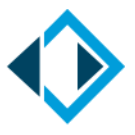 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Fielddata</span></a>